模块导入

In [1]:
#导入基本包
import copy
import random
import math
import os
import numpy as np
import pandas as pd
#导入模型计算基本包
import torch
import torch.nn as nn
from torch.nn import functional as F
from transformers import BertTokenizer
#数据及模型处理
from d2l import torch as d2l
import torchvision.models as models
from torch.utils.data import TensorDataset, DataLoader, random_split
#评估绘图包
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
'''
#设置环境变量免责声明
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
'''

"\n#设置环境变量免责声明\nos.environ['KMP_DUPLICATE_LIB_OK'] = 'True'\n"

固定随机数

In [2]:
def setup_seed(seed):
	#  下面两个常规设置了，用来np和random的话要设置 
    np.random.seed(seed) 
    random.seed(seed)

    os.environ['PYTHONHASHSEED'] = str(seed)
    # 禁止hash随机化
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    # 在cuda 10.2及以上的版本中，需要设置以下环境变量来保证cuda的结果可复现

    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)# 多GPU训练需要设置这个
    torch.manual_seed(seed)

    torch.use_deterministic_algorithms(True)
    # 一些操作使用了原子操作，不是确定性算法，不能保证可复现，设置这个禁用原子操作，保证使用确定性算法
    torch.backends.cudnn.deterministic = True 
    # 确保每次返回的卷积算法是确定的
    torch.backends.cudnn.enabled = False
    # 禁用cudnn使用非确定性算法
    torch.backends.cudnn.benchmark = False
    # 与上面一条代码配套使用，True的话会自动寻找最适合当前配置的高效算法，来达到优化运行效率的问题。
    # False保证实验结果可复现。

定义基本类和函数

In [3]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        #d_model: word embedding维度
        #vocab: 语料库词的数量
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        #x: 一个batch的输入，size = [batch, L], L为batch中最长句子长度
        return self.lut(x) * math.sqrt(self.d_model)  
        #这里乘了一个权重，不改变维度. size = [batch, L, d_model]

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        #d_model: pe编码维度，一般与word embedding相同，方便相加
        #dropout: dorp out
        #max_len: 语料库中最长句子的长度，即word embedding中的L

        super(PositionalEncoding, self).__init__()
        #定义drop out
        self.dropout = nn.Dropout(p=dropout)

        #计算pe编码
        pe = torch.zeros(max_len, d_model) 
        #建立空表，每行代表一个词的位置，每列代表一个编码位
        position = torch.arange(0, max_len).unsqueeze(1) 
        #建个arrange表示词的位置以便公式计算，size=(max_len,1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *    #计算公式中10000**（2i/d_model)
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term) #计算偶数维度的pe值
        pe[:, 1::2] = torch.cos(position * div_term) #计算奇数维度的pe值
        pe = pe.unsqueeze(0)
        #size=(1, L, d_model)，为了后续与word_embedding相加,意为batch维度下的操作相同
        self.register_buffer('pe', pe)
        #pe值是不参加训练的

    def forward(self, x):
        #输入的最终编码 = word_embedding + positional_embedding
        x = x + torch.tensor(self.pe[:, :x.size(1)],requires_grad=False) #size = [batch, L, d_model]
        return self.dropout(x) #size = [batch, L, d_model]

In [5]:
#实现mask方式
class Batch:
    def __init__(self, src, trg=None, pad=0):
        #src: 一个batch的输入，size = [batch, src_L]
        #trg: 一个batch的输出，size = [batch, tgt_L]
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        #返回一个true/false矩阵，size = [batch , 1 , src_L]
        if trg is not None:
            self.trg = trg[:, :-1]   #用于输入模型，不带末尾的<eos>
            self.trg_y = trg[:, 1:]  #用于计算损失函数，不带起始的<sos>
            self.trg_mask = self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    @staticmethod
    def make_std_mask(tgt, pad):
        #tgt: 一个batch的target，size = [batch, tgt_L]
        #pad: 用于padding的值,一般为0
        tgt_mask = (tgt != pad).unsqueeze(-2) # 返回一个true/false矩阵，size = [batch , 1 , tgt_L]
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))  
        #两个mask求和得到最终mask,[batch, 1, L]&[1, size, size]=[batch,tgt_L,tgt_L]
        return tgt_mask  # size = [batch, tgt_L, tgt_L]

def subsequent_mask(size):
    #size: 输出的序列长度
    #return: 返回下三角矩阵，size = [1, size, size]
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')   #返回上三角矩阵，不带轴线
    return torch.from_numpy(subsequent_mask) == 0  #返回==0的部分，其实就是下三角矩阵

In [6]:
def attention(query, key, value, mask=None, dropout=None):
    """
    实现 Scaled Dot-Product Attention
    query: 输入与Q矩阵相乘后的结果,size = (batch , h , L , d_model//h)
    key: 输入与K矩阵相乘后的结果,size同上
    value: 输入与V矩阵相乘后的结果，size同上
    mask: 掩码矩阵
    dropout: 丢弃
    """
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    #计算QK/根号d_k，size=(batch,h,L,L)
    if mask is not None:
        #掩码矩阵，编码器mask的size = [batch,1,1,src_L],解码器mask的size= = [batch,1,tgt_L,tgt_L]
        scores = scores.masked_fill(mask=mask, value=torch.tensor(-1e9))
    p_attn = F.softmax(scores, dim = -1)
    #以最后一个维度进行softmax(也就是最内层的行),size = (batch,h,L,L)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn
    #与V相乘。第一个输出的size为(batch,h,L,d_model//h),第二个输出的size = (batch,h,L,L)

In [7]:
def clones(module, N):
    "工具函数，定义N个相同的模块"
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout):
        """
        实现多头注意力机制
        h: 头数
        d_model: word embedding维度
        dropout:丢弃率
        """
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0  #检测word embedding维度是否能被h整除
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h  # 头的个数
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        #四个线性变换，前三个为QKV三个变换矩阵，最后一个用于attention后
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        """
        query: 输入x，即(word embedding+postional embedding)，size=[batch, L, d_model]
               tips:编解码器输入的L可能不同
        key: 同上，size同上
        value: 同上，size同上
        mask: 掩码矩阵，编码器mask的size = [batch , 1 , src_L],解码器mask的size = [batch, tgt_L, tgt_L]
        """
        if mask is not None:
            #在"头"的位置增加维度，意为对所有头执行相同的mask操作
            mask = mask.unsqueeze(1)  
            #编码器mask的size = [batch,1,1,src_L],解码器mask的size= = [batch,1,tgt_L,tgt_L]
        nbatches = query.size(0) 
        #获取batch的值，nbatches = batch

        #1)利用三个全连接算出QKV向量，再维度变换 [batch,L,d_model] ----> [batch , h , L , d_model//h]
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)  
             #view中给-1可以推测这个位置的维度
             for l, x in zip(self.linears, (query, key, value))]

        #2)实现Scaled Dot-Product Attention。
        x, self.attn = attention(query, key, value, mask=mask,dropout=self.dropout)
        #x的size = (batch,h,L,d_model//h)，attn的size = (batch,h,L,L)

        #3)拼接：transpose的结果size=(batch , L , h , d_model//h)，view的结果size=(batch , L , d_model)
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)

        return self.linears[-1](x)   # size = (batch , L , d_model)

In [8]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        #层归一化
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features)) 
        #类似BN层原理，对归一化后的结果进行线性偏移，feature=d_model，相当于每个embedding维度偏移不同的倍数
        self.b_2 = nn.Parameter(torch.zeros(features))
        #偏置。系数和偏置都为可训练的量
        self.eps = eps
        #保证归一化分母不为0

    def forward(self, x):
        #x: 输入size = (batch , L , d_model)
        #return: 归一化后的结果，size同上
        mean = x.mean(-1, keepdim=True) #最后一个维度求均值
        std = x.std(-1, keepdim=True)  #最后一个维度求方差
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2 #归一化并线性放缩+偏移

In [9]:
class SublayerConnection(nn.Module):
    #残差连接
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)   # 读入层归一化函数
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        #x: 当前子层的输入，size = [batch , L , d_model]
        #sublayer: 当前子层的前向传播函数，指代多头attention或前馈神经网络
        return self.norm(x + self.dropout(sublayer(x)))
        #这里把归一化已经封装进来，size = [batch , L , d_model]

In [10]:
class PositionwiseFeedForward(nn.Module):
    #全连接层
    def __init__(self, d_model, d_ff, dropout):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #x: size = [batch , L , d_model]
        #return: size同上
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [11]:
class EncoderLayer(nn.Module):
    #Encoder层整体的封装，由self attention、残差连接、归一化和前馈神经网络组成
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn 
        #定义多头注意力，即传入一个MultiHeadedAttention类
        self.feed_forward = feed_forward
        #定义前馈，即传入一个PositionwiseFeedForward类
        self.sublayer = clones(SublayerConnection(size, dropout), 2)  
        #克隆两个残差连接，一个用于多头attention后，一个用于前馈神经网络后
        self.size = size

    def forward(self, x, mask):
        #x: 输入x，即(word embedding+postional embedding)，size = [batch, L, d_model]
        #mask: 掩码矩阵，编码器mask的size = [batch , 1 , src_L],解码器mask的size = [batch, tgt_L, tgt_L]
        #return: size = [batch, L, d_model]

        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        #实现多头attention和残差连接,size = [batch , L , d_model]
        return self.sublayer[1](x, self.feed_forward)
        #实现前馈和残差连接, size = [batch , L , d_model]

In [12]:
class Encoder(nn.Module):
    #Encoder最终封装，由若干个Encoder Layer组成
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)  #N层Encoder Layer
        self.norm = LayerNorm(layer.size) #最终输出进行归一化

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [13]:
class DecoderLayer(nn.Module):
    #解码器由self attention、编码解码self-attention、前馈神经网络组成
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size   #embedding的维度
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        #克隆3个sublayer分别装以上定义的三个部分

    def forward(self, x, memory, src_mask, tgt_mask):
        #x: target，size = [batch, tgt_L, d_model]
        #memory: encoder的输出，size = [batch, src_L, d_model]
        #src_mask: 源数据的mask, size = [batch, 1, src_L]
        #tgt_mask: 标签的mask，size = [batch, tgt_L, tgt_L]
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        #self-atten、add&norm，和编码器一样, size = [batch, tgt_L, d_model]
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        #编码解码-attention、add&norm，Q来自target，KV来自encoder的输出，size = [batch, tgt_L, d_model]
        return self.sublayer[2](x, self.feed_forward) # 前馈+add&norm, size = [batch, tgt_L, d_model]

In [14]:
class Decoder(nn.Module):
    #解码器的高层封装，由N个Decoder layer组成
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x) #size = [batch, tgt_L, d_model]

In [15]:
class EncoderDecoder(nn.Module):
    #编码解码架构
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder  #编码器
        self.decoder = decoder  #解码器
        self.src_embed = src_embed  #源的embedding
        self.tgt_embed = tgt_embed  #目标的embedding
        self.generator = generator  #定义最后的线性变换与softmax

    def forward(self, src, tgt, src_mask, tgt_mask):  #编码解码过程
        return self.decode(self.encode(src, src_mask), src_mask,
                           tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [16]:
class Generator(nn.Module):
    #定义一个全连接层+softmax
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)  # vocab为整个词袋的词数

    def forward(self, x):
        #x: 输入的 size = [batch, tgt_L, d_model]
        return F.log_softmax(self.proj(x), dim=-1)  #dim=-1在最后一维上做softmax

In [17]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    #Helper: Construct a model from hyperparameters.
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model, dropout)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

数据读取与预处理、保存

In [18]:
def data_preprocessing(data_dir,data_sava_dir,tokenizer,max_length,data_num):
    questions = []
    answers = []
    src_vocab = set()
    tgt_vocab = set()
    
    with open(data_dir,encoding='gb18030') as f:
        for i in range(0,data_num+1):
            lin = f.readline()[0:-1].split(',')
            if i==0:
                continue        
            #print(lin)
            if len(lin) == 4:
                if len(lin[1]+','+lin[2])<max_length and len(lin[3])<max_length:
                    question = lin[1]+','+lin[2]
                    answer = lin[3]
                    questions.append(question)
                    answers.append(answer)

    #获取批量token
    batch_encode_src = tokenizer.batch_encode_plus(questions,
                                                add_special_tokens=True,
                                                truncation=True,
                                                padding="max_length",
                                                max_length=max_length,
                                                return_attention_mask=True,
                                                return_tensors="pt")
    batch_encode_tgt = tokenizer.batch_encode_plus(answers,
                                                add_special_tokens=True,
                                                truncation=True,
                                                padding="max_length",
                                                max_length=max_length,
                                                return_attention_mask=True,
                                                return_tensors="pt")
    
    #保存token
    src_token = {"input_ids": batch_encode_src["input_ids"].tolist(),
                "attention_mask": batch_encode_src["attention_mask"].tolist()}
    with open(data_sava_dir+'/batch_encode_src.txt', 'w') as file:
        file.write(str(src_token))

    tgt_token = {"input_ids": batch_encode_tgt["input_ids"].tolist(),
                "attention_mask": batch_encode_tgt["attention_mask"].tolist()}
    with open(data_sava_dir+'/batch_encode_tgt.txt', 'w') as file:
        file.write(str(tgt_token))

    #制作并保存字典
    vocab = tokenizer.get_vocab()
    with open(data_sava_dir+'/bert_base_chinese_vocab.txt', 'w', encoding='utf-8') as f:
        for token in sorted(vocab.keys()):
            f.write(token + '\n')
    
    return vocab,batch_encode_src,batch_encode_tgt

评估函数模块

In [19]:
#精度评估函数
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

训练函数

In [20]:
def train(model, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    model.apply(init_weights)
    print('training on', device)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        model.train()
        for i,(src, tgt, src_mask, tgt_mask) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            src, tgt = src.to(device), tgt.to(device)
            src_mask, tgt_mask = src_mask.to(device), tgt_mask.to(device)
            output = model(src,tgt,src_mask,tgt_mask)
            l = loss(output.view(-1,d_model), tgt.view(-1))
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * src.shape[0], d2l.accuracy(output, tgt), src.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(model, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

主模块

In [21]:
def main():
    #数据处理
    vocab,src_token,tgt_token = data_preprocessing(data_dir,data_sava_dir,tokenizer,
                                                    max_length,data_num)

    # 从src_token中提取相关信息
    src = src_token["input_ids"]
    src_mask = src_token["attention_mask"]

    # 从src_token中提取相关信息
    tgt = tgt_token["input_ids"]
    tgt_mask = tgt_token["attention_mask"]

    # 创建TensorDataset对象
    dataset = TensorDataset(src, tgt, src_mask, tgt_mask)

    # 计算训练集的大小
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    # 分割数据集为训练集和测试集
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # 创建DataLoader对象
    train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    #定义模型和训练模块
    model = make_model(len(vocab), len(vocab),N,d_model, d_ff, h, dropout)
    
    #训练
    train(model, train_iter, test_iter, num_epochs, lr, device)
    
    #保存模型
    torch.save(model,model_save_dir)

参数设置

In [22]:
#设置参数
device = d2l.try_gpu()#设置运行模式：CPU/GPU
batch_size, lr, num_epochs = 20, 0.0001, 100#设置批量、学习率和迭代次数
data_dir = '../../数据/chinese medical dialogue_datasets/IM_内科/内科5000-33000.csv'#设置文件读取路径
model_save_dir = './model_.pt'#设置保存路径
data_sava_dir = './predata'#设置字典保存路径

# 设置随机数种子
seed = 0
# 设置数据总量
data_num = 220607
# 设置语句最大长度
max_length = 200
# 创建Bert分词器
tokenizer = BertTokenizer.from_pretrained(
    pretrained_model_name_or_path='bert-base-chinese',
    cache_dir='./tokenizer',
    force_download=False)
#设置模型超参数
N, d_model, d_ff, h, dropout = 6, 512, 2048, 8, 0.1

'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /bert-base-chinese/resolve/main/tokenizer_config.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000206FB6773D0>, 'Connection to huggingface.co timed out. (connect timeout=10)'))"), '(Request ID: 878300ef-ac0b-440f-9b7d-1125197105bf)')' thrown while requesting HEAD https://huggingface.co/bert-base-chinese/resolve/main/tokenizer_config.json


C:\Users\17132\AppData\Local\Temp\ipykernel_29832\281436635.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


training on cuda:0


C:\Users\17132\AppData\Local\Temp\ipykernel_29832\3450645558.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = x + torch.tensor(self.pe[:, :x.size(1)],requires_grad=False) #size = [batch, L, d_model]


RuntimeError: The size of tensor a (20) must match the size of tensor b (8) at non-singleton dimension 1

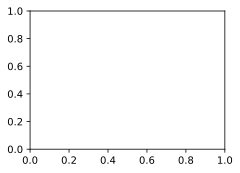

In [23]:
if __name__ == '__main__':
    main()